In [1]:
import instruments as inst
import copy
import numpy as np
import json

ModuleNotFoundError: No module named 'instruments'

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [9]:
file_path = "20230914_processed_table.csv"
wavelength_string = "775-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
# print("Interleaved Values")
# print("Length: ", len(interleaved_values))
# print(interleaved_values)
# print("Interleaved Stds")
# print("Length: ", len(interleaved_stds))
# print(interleaved_stds[0 : 10])
# print("Configuration List")
# print("Length: ", len(configuration_list))
# print(configuration_list)
# print(interleaved_stds[0])

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [10]:
# Loading in previous fit from vampires_calibration
filename = "775-50_restrictive_HWP_FLC_no_IMR_offset_fixed_EM_gain_with_dichroic_best_fit.txt"
with open(filename, "r") as f:
    past_fit = json.load(f)

print(past_fit)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"]
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
# em_gain = past_fit["wollaston"]["transmission_ratio"]
em_gain = 1.19 # from the dark-subtracted images

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.64  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 0, 'epsilon': 0, 'theta': 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 2 * np.pi * delta_opts, 'epsilon': epsilon_opts, 'theta': rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

print(system_dict)

{'dichroic': {'phi': -0.15060529133346875, 'epsilon': 0.2947260746883915, 'theta': 35.808129724830195}, 'flc': {'phi': 3.5231674749347714, 'delta_theta': 2.547063907771257}, 'optics': {'phi': 0.8366868576245823, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}, 'image_rotator': {'phi': 3.0680237129197785}, 'hwp': {'phi': 2.9838983981947838, 'delta_theta': 0.5155838549975353}, 'lp': {'theta': 0.674229408746958}}
{'components': {'wollaston': {'type': 'wollaston_prism_function', 'properties': {'beam': 'o', 'transmission_ratio': 0.8374186590182964}}, 'dichroic': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 0, 'epsilon': 0, 'theta': 0}}, 'flc': {'type': 'general_retarder_function', 'properties': {'phi': 22.13671411324316, 'theta': 0, 'delta_theta': 2.547063907771257}}, 'optics': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 5.257058570537033, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}}, 'image_rotator': {'type': 'gen

In [11]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.35318972 0.35309191 0.00831157 0.        ]
 [0.35318972 0.35309191 0.00831157 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 1403.8714594287703


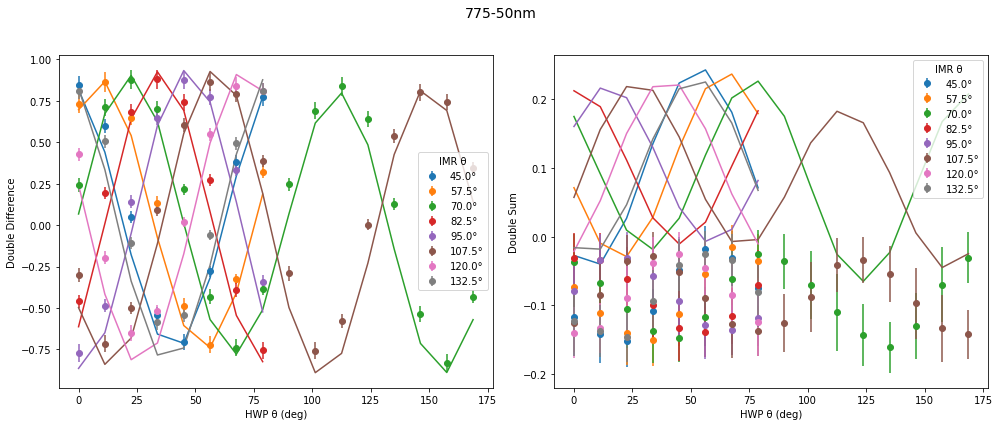

In [12]:
# Fittin for all parameters
p0 = {
    "dichroic": {"phi": 0, 
                 "epsilon": 0, 
                 "theta": 0},
    "flc": {"phi": delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {
                    "phi":delta_derot, 
                    # "delta_theta": 0
                    },
    "hwp": {"phi": delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

In [13]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds = [ 
    (-2 * np.pi, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    (-2 * np.pi, 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (-np.pi, np.pi),  # delta_opts
    (0, 1),  # epsilon_opts
    (-90, 90),  # rot_opts
    (-2 * np.pi, 2 * np.pi),  # delta_derot
    # (-1, 1),  # offset_derot
    (-2 * np.pi, 2 * np.pi),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5),  # theta_pol
]
# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_no_IMR_offset_or_HWP_IMR_FLC_retardance_bounds_fixed_EM_gain_with_dichroic_best_fit.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

Before p0: {'dichroic': {'phi': 0, 'epsilon': 0, 'theta': 0}, 'flc': {'phi': 3.5231674749347714, 'delta_theta': 2.547063907771257}, 'optics': {'phi': 0.8366868576245823, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}, 'image_rotator': {'phi': 3.0680237129197785}, 'hwp': {'phi': 2.9838983981947838, 'delta_theta': 0.5155838549975353}, 'lp': {'theta': 0.674229408746958}}


KeyboardInterrupt: 

# Step 6: Plot model with best fit

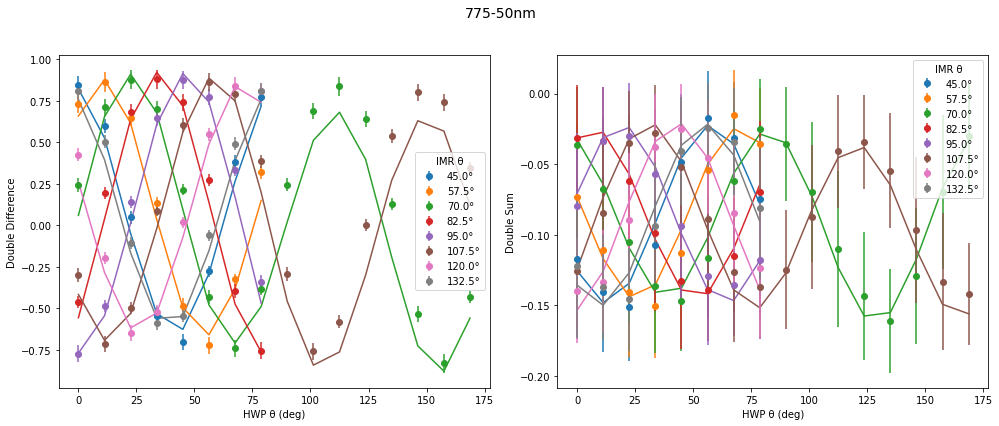

In [7]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)